# 01.01 - PROYECTO KAGGLE

In [2]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/ai4eng.v1/main/content/init.py
import init; init.init(force_download=False); init.get_weblink()

replicating local resources


## download data directly from Kaggle

- create a file `kaggle.json` with your authentication token (in kaggle $\to$ click user icon on top-right $\to$ settings $\to$ API create new token)
- upload it to this notebook workspace
- run the following cell

In [4]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '.'
!chmod 600 ./kaggle.json
!kaggle competitions download -c udea-ai4eng-20242

  0% 0.00/20.1M [00:00<?, ?B/s]
100% 20.1M/20.1M [00:00<00:00, 238MB/s]


## unzip and inspect data

In [5]:
!unzip udea*.zip > /dev/null

In [6]:
!wc *.csv

   296787    296787   4716673 submission_example.csv
   296787   4565553  50135751 test.csv
   692501  10666231 118025055 train.csv
  1286075  15528571 172877479 total


## load `train.csv` data with pandas



In [7]:
import pandas as pd
import numpy as np

z = pd.read_csv("train.csv")
print ("shape of loaded dataframe", z.shape)


shape of loaded dataframe (692500, 12)


In [8]:
z.head()

,ID,PERIODO,ESTU_PRGM_ACADEMICO,ESTU_PRGM_DEPARTAMENTO,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_HORASSEMANATRABAJA,FAMI_ESTRATOVIVIENDA,FAMI_TIENEINTERNET,FAMI_EDUCACIONPADRE,FAMI_EDUCACIONMADRE,ESTU_PAGOMATRICULAPROPIO,RENDIMIENTO_GLOBAL
0,904256,20212,ENFERMERIA,BOGOTÁ,Entre 5.5 millones y menos de 7 millones,Menos de 10 horas,Estrato 3,Si,Técnica o tecnológica incompleta,Postgrado,No,medio-alto
1,645256,20212,DERECHO,ATLANTICO,Entre 2.5 millones y menos de 4 millones,0,Estrato 3,No,Técnica o tecnológica completa,Técnica o tecnológica incompleta,No,bajo
2,308367,20203,MERCADEO Y PUBLICIDAD,BOGOTÁ,Entre 2.5 millones y menos de 4 millones,Más de 30 horas,Estrato 3,Si,Secundaria (Bachillerato) completa,Secundaria (Bachillerato) completa,No,bajo
3,470353,20195,ADMINISTRACION DE EMPRESAS,SANTANDER,Entre 4 millones y menos de 5.5 millones,0,Estrato 4,Si,No sabe,Secundaria (Bachillerato) completa,No,alto
4,989032,20212,PSICOLOGIA,ANTIOQUIA,Entre 2.5 millones y menos de 4 millones,Entre 21 y 30 horas,Estrato 3,Si,Primaria completa,Primaria completa,No,medio-bajo


## we will do a model using only two columns

- we have to predict column `RENDIMIENTO_GLOBAL` using the rest

- we will use columns
  - `FAMI_EDUCACIONPADRE` which we will need to convert to a **onehot encoding**
  - `ESTU_VALORMATRICULAUNIVERSIDAD` which we will need to convert to a **continuous encoding**

In [9]:
z = z[['FAMI_EDUCACIONPADRE', 'ESTU_VALORMATRICULAUNIVERSIDAD', 'RENDIMIENTO_GLOBAL']]
z.head()

,FAMI_EDUCACIONPADRE,ESTU_VALORMATRICULAUNIVERSIDAD,RENDIMIENTO_GLOBAL
0,Técnica o tecnológica incompleta,Entre 5.5 millones y menos de 7 millones,medio-alto
1,Técnica o tecnológica completa,Entre 2.5 millones y menos de 4 millones,bajo
2,Secundaria (Bachillerato) completa,Entre 2.5 millones y menos de 4 millones,bajo
3,No sabe,Entre 4 millones y menos de 5.5 millones,alto
4,Primaria completa,Entre 2.5 millones y menos de 4 millones,medio-bajo


<Axes: xlabel='FAMI_EDUCACIONPADRE'>

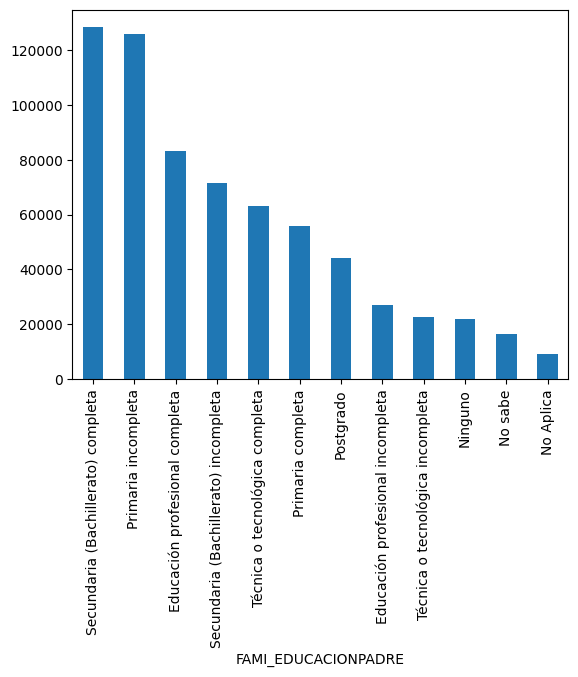

In [10]:
z.FAMI_EDUCACIONPADRE.value_counts().plot(kind='bar')

<Axes: xlabel='ESTU_VALORMATRICULAUNIVERSIDAD'>

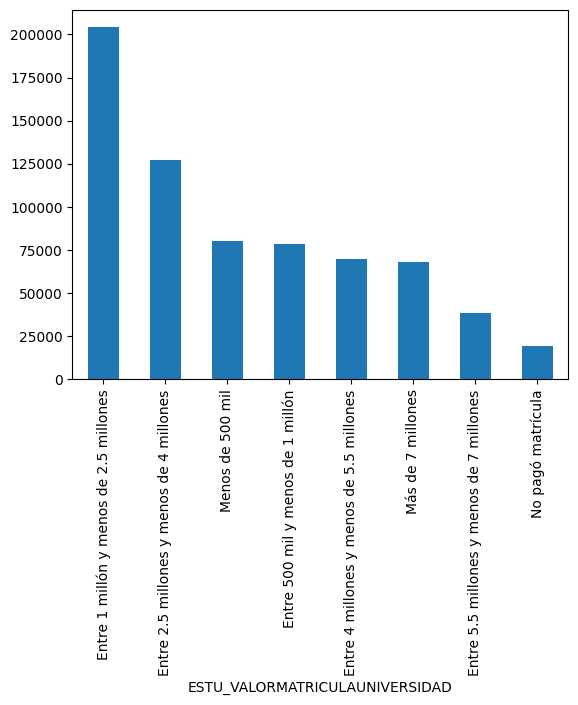

In [11]:
z.ESTU_VALORMATRICULAUNIVERSIDAD.value_counts().plot(kind='bar')

## Inspect visually if these two columns have distinctive behaviour with respect to what we want to predict

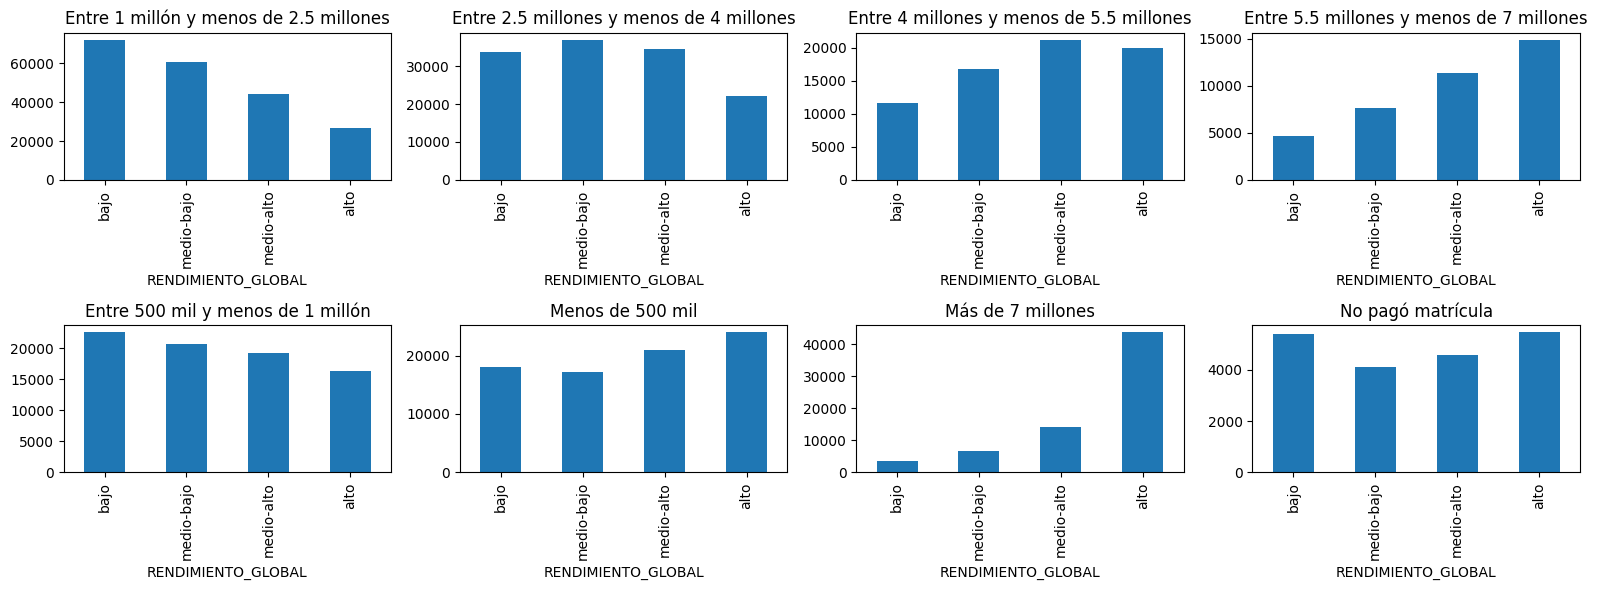

In [12]:
from rlxutils import subplots
import matplotlib.pyplot as plt

c = sorted(z.ESTU_VALORMATRICULAUNIVERSIDAD.value_counts().index)
for ax,ci in subplots(c, n_cols=4, usizex=4):
    zc = z[z.ESTU_VALORMATRICULAUNIVERSIDAD==ci]
    zc.RENDIMIENTO_GLOBAL.value_counts()[['bajo', 'medio-bajo', 'medio-alto', 'alto']].plot(kind='bar')
    plt.title(ci)

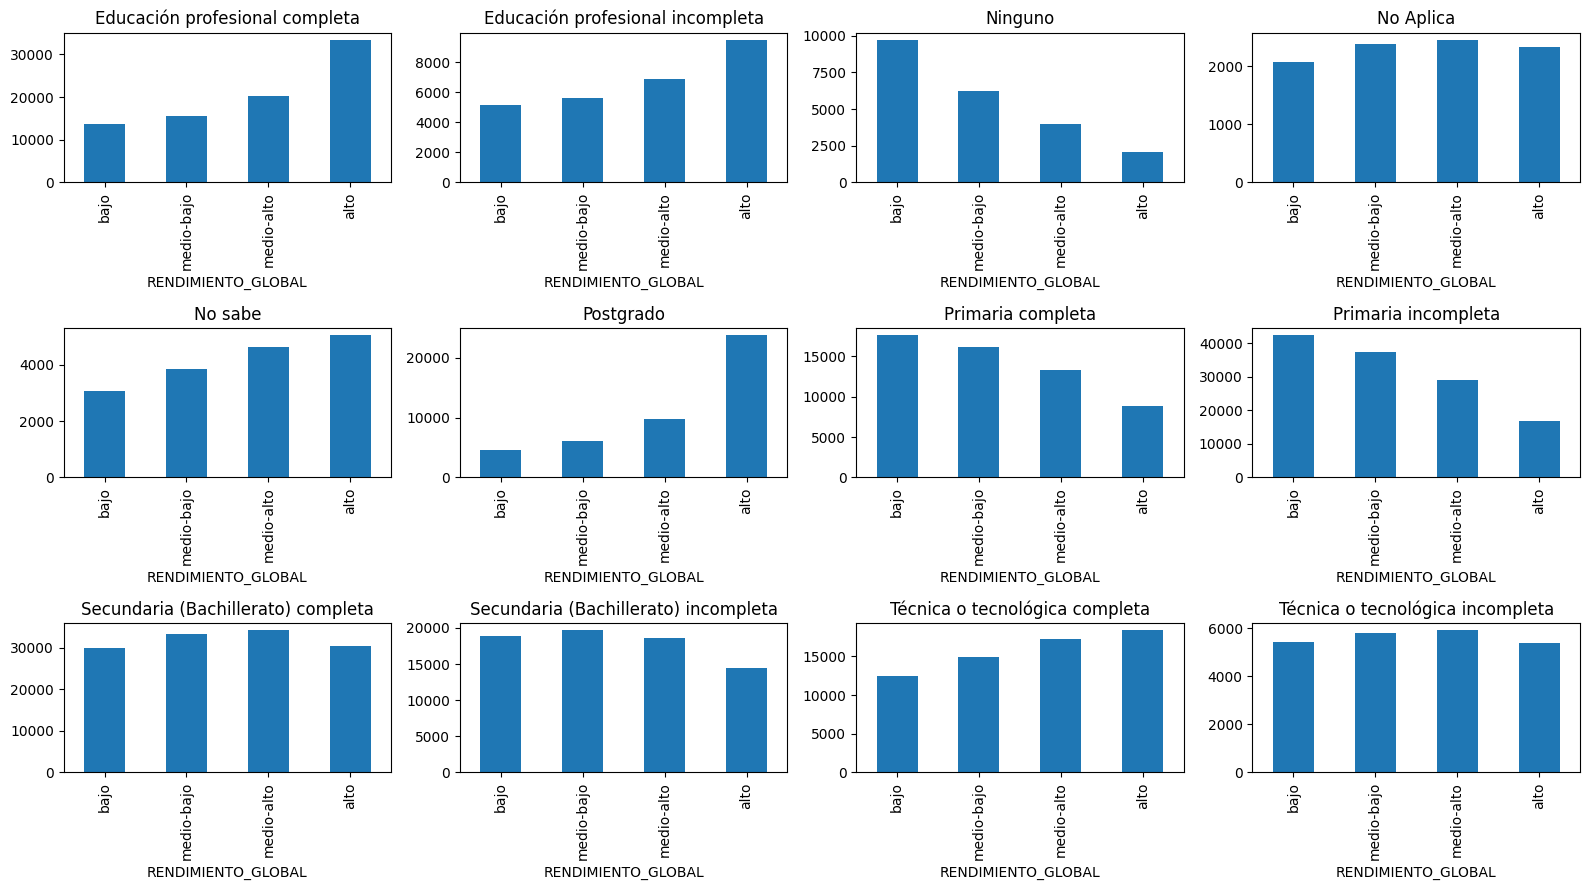

In [13]:
c = sorted(z.FAMI_EDUCACIONPADRE.value_counts().index)
for ax,ci in subplots(c, n_cols=4, usizex=4):
    zc = z[z.FAMI_EDUCACIONPADRE==ci]
    zc.RENDIMIENTO_GLOBAL.value_counts()[['bajo', 'medio-bajo', 'medio-alto', 'alto']].plot(kind='bar')
    plt.title(ci)

## Basic cleanup

considering that we have in total 692K data items, we have realatively few missing values on each column

In [14]:
sum(z.FAMI_EDUCACIONPADRE.isna()), sum(z.ESTU_VALORMATRICULAUNIVERSIDAD.isna())

(23178, 6287)

we will substitute `nan` values with a preset symbol to mark them

In [15]:
z.FAMI_EDUCACIONPADRE.values[z.FAMI_EDUCACIONPADRE.isna()] = 'no info'
z.ESTU_VALORMATRICULAUNIVERSIDAD.values[z.ESTU_VALORMATRICULAUNIVERSIDAD.isna()] = 'no info'
sum(z.FAMI_EDUCACIONPADRE.isna()), sum(z.ESTU_VALORMATRICULAUNIVERSIDAD.isna())

(0, 0)

### Cleaning `ESTU_VALORMATRICULAUNIVERSIDAD`

we convert `ESTU_VALORMATRICULAUNIVERSIDAD` to a **continuous** value since the ordering makes sense and we would like models to have a chance to capture it.

observe we assign `no info` to -1, which is somewhat artificial in this case

In [16]:
# Mapeo de valores categóricos a numéricos para la columna ESTU_VALORMATRICULAUNIVERSIDAD
cmap = {
    'Entre 1 millón y menos de 2.5 millones': 1.75,
    'Entre 2.5 millones y menos de 4 millones': 3.25,
    'Menos de 500 mil': 0.250,
    'Entre 500 mil y menos de 1 millón': 0.75,
    'Entre 4 millones y menos de 5.5 millones': 4.75,
    'Más de 7 millones': 7.75,
    'Entre 5.5 millones y menos de 7 millones': 6.25,
    'No pagó matrícula': 0,
    'no info': -1
}

# Transformación de los valores categóricos en numéricos con pandas `.map()`
z['ESTU_VALORMATRICULAUNIVERSIDAD'] = z['ESTU_VALORMATRICULAUNIVERSIDAD'].map(cmap)

# Verificar si hubo valores no mapeados
missing_values = z['ESTU_VALORMATRICULAUNIVERSIDAD'].isna().sum()
if missing_values > 0:
    print(f"Advertencia: Hay {missing_values} valores no mapeados. Revisa la columna o ajusta el cmap.")

# Conteo de valores transformados
print(z['ESTU_VALORMATRICULAUNIVERSIDAD'].value_counts())


ESTU_VALORMATRICULAUNIVERSIDAD
 1.75    204048
 3.25    127430
 0.25     80263
 0.75     78704
 4.75     69736
 7.75     68014
 6.25     38490
 0.00     19528
-1.00      6287
Name: count, dtype: int64


In [ ]:
#cmap = {'Entre 1 millón y menos de 2.5 millones': 1.75,
 #'Entre 2.5 millones y menos de 4 millones': 3.25,
 #'Menos de 500 mil': .250,
 #'Entre 500 mil y menos de 1 millón': .75,
 #'Entre 4 millones y menos de 5.5 millones': 4.75,
 #'Más de 7 millones': 7.75,
 #'Entre 5.5 millones y menos de 7 millones': 6.25,
 #'No pagó matrícula': 0,
 #'no info': -1}

#z.ESTU_VALORMATRICULAUNIVERSIDAD = np.r_[[cmap[i] for i in z.ESTU_VALORMATRICULAUNIVERSIDAD]]
#z.ESTU_VALORMATRICULAUNIVERSIDAD.value_counts()

,count
ESTU_VALORMATRICULAUNIVERSIDAD,
1.75,204048
3.25,127430
0.25,80263
0.75,78704
4.75,69736
7.75,68014
6.25,38490
0.00,19528
-1.00,6287


### Cleaning `FAMI_EDUCACIONMADRE`

observe that for `FAMI_EDUCACIONMADRE` there could be many choices on how to deal with missing data

- leave it as it is
- unite `no info`, `No sabe` , `No Aplica` into a single symbol
- etc.

since there are not so many `No sabe`, `No aplica` probably they wont have much effect on the final result so we will unite them into a single value so that there are not so many columns in the one hot encoding


In [17]:
z = z.copy()

# Lista de valores a reemplazar por 'no info'
valores_no_info = ['No sabe', 'No Aplica']

# Reemplazar los valores usando pandas .replace() para mayor eficiencia y claridad
z['FAMI_EDUCACIONPADRE'] = z['FAMI_EDUCACIONPADRE'].replace(valores_no_info, 'no info')


In [ ]:
#z = z.copy()
#z.FAMI_EDUCACIONPADRE = ['no info' if i in ['No sabe', 'No Aplica'] else i for i in z.FAMI_EDUCACIONPADRE.values]

In [18]:
z.FAMI_EDUCACIONPADRE.value_counts()

,count
FAMI_EDUCACIONPADRE,
Secundaria (Bachillerato) completa,128289
Primaria incompleta,125675
Educación profesional completa,83117
Secundaria (Bachillerato) incompleta,71654
Técnica o tecnológica completa,62995
Primaria completa,55958
no info,48999
Postgrado,44169
Educación profesional incompleta,27084


first we create the onehot mapping

In [ ]:
#x = z.FAMI_EDUCACIONPADRE.values
#FAMI_EDUCACIONPADRE_vals = sorted(np.unique(x))
#FAMI_EDUCACIONPADRE_onehot_vals = {val: np.eye(len(FAMI_EDUCACIONPADRE_vals))[i] for i,val in enumerate(FAMI_EDUCACIONPADRE_vals)}
#FAMI_EDUCACIONPADRE_onehot_vals

{'Educación profesional completa': array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'Educación profesional incompleta': array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'Ninguno': array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'Postgrado': array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
 'Primaria completa': array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]),
 'Primaria incompleta': array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]),
 'Secundaria (Bachillerato) completa': array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 'Secundaria (Bachillerato) incompleta': array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]),
 'Técnica o tecnológica completa': array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]),
 'Técnica o tecnológica incompleta': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]),
 'no info': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])}

In [19]:
# Crear un mapeo one-hot para FAMI_EDUCACIONPADRE
FAMI_EDUCACIONPADRE_vals = z['FAMI_EDUCACIONPADRE'].unique()
FAMI_EDUCACIONPADRE_onehot_vals = {
    val: pd.get_dummies(FAMI_EDUCACIONPADRE_vals)[val].values
    for val in FAMI_EDUCACIONPADRE_vals
}

# Mostrar el mapeo one-hot
FAMI_EDUCACIONPADRE_onehot_vals


{'Técnica o tecnológica incompleta': array([ True, False, False, False, False, False, False, False, False,
        False, False]),
 'Técnica o tecnológica completa': array([False,  True, False, False, False, False, False, False, False,
        False, False]),
 'Secundaria (Bachillerato) completa': array([False, False,  True, False, False, False, False, False, False,
        False, False]),
 'no info': array([False, False, False,  True, False, False, False, False, False,
        False, False]),
 'Primaria completa': array([False, False, False, False,  True, False, False, False, False,
        False, False]),
 'Educación profesional completa': array([False, False, False, False, False,  True, False, False, False,
        False, False]),
 'Educación profesional incompleta': array([False, False, False, False, False, False,  True, False, False,
        False, False]),
 'Primaria incompleta': array([False, False, False, False, False, False, False,  True, False,
        False, False]),
 'Postg

In [20]:
FAMI_EDUCACIONPADRE_onehot_enc = np.r_[[FAMI_EDUCACIONPADRE_onehot_vals[i] for i in z.FAMI_EDUCACIONPADRE]]
FAMI_EDUCACIONPADRE_onehot_enc

array([[ True, False, False, ..., False, False, False],
       [False,  True, False, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       ...,
       [False, False,  True, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False,  True, ..., False, False, False]])

In [21]:
FAMI_EDUCACIONPADRE_df = pd.DataFrame(FAMI_EDUCACIONPADRE_onehot_enc, columns=[f"FAMI_EDUCACIONPADRE__{v}" for v in FAMI_EDUCACIONPADRE_onehot_vals])
FAMI_EDUCACIONPADRE_df

,FAMI_EDUCACIONPADRE__Técnica o tecnológica incompleta,FAMI_EDUCACIONPADRE__Técnica o tecnológica completa,FAMI_EDUCACIONPADRE__Secundaria (Bachillerato) completa,FAMI_EDUCACIONPADRE__no info,FAMI_EDUCACIONPADRE__Primaria completa,FAMI_EDUCACIONPADRE__Educación profesional completa,FAMI_EDUCACIONPADRE__Educación profesional incompleta,FAMI_EDUCACIONPADRE__Primaria incompleta,FAMI_EDUCACIONPADRE__Postgrado,FAMI_EDUCACIONPADRE__Secundaria (Bachillerato) incompleta,FAMI_EDUCACIONPADRE__Ninguno
0,True,False,False,False,False,False,False,False,False,False,False
1,False,True,False,False,False,False,False,False,False,False,False
2,False,False,True,False,False,False,False,False,False,False,False
3,False,False,False,True,False,False,False,False,False,False,False
4,False,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
692495,False,False,True,False,False,False,False,False,False,False,False
692496,False,False,False,False,False,False,False,True,False,False,False
692497,False,False,True,False,False,False,False,False,False,False,False
692498,False,False,False,False,True,False,False,False,False,False,False


and we assemble everything into a single dataframe, removing the original `FAMI_EDUCACIONPADRE` column.

we now have 13 columns ... why?


In [22]:
z = pd.concat([FAMI_EDUCACIONPADRE_df, z], axis=1).drop('FAMI_EDUCACIONPADRE', axis=1)
z.shape

(692500, 13)

In [23]:
z.head()

,FAMI_EDUCACIONPADRE__Técnica o tecnológica incompleta,FAMI_EDUCACIONPADRE__Técnica o tecnológica completa,FAMI_EDUCACIONPADRE__Secundaria (Bachillerato) completa,FAMI_EDUCACIONPADRE__no info,FAMI_EDUCACIONPADRE__Primaria completa,FAMI_EDUCACIONPADRE__Educación profesional completa,FAMI_EDUCACIONPADRE__Educación profesional incompleta,FAMI_EDUCACIONPADRE__Primaria incompleta,FAMI_EDUCACIONPADRE__Postgrado,FAMI_EDUCACIONPADRE__Secundaria (Bachillerato) incompleta,FAMI_EDUCACIONPADRE__Ninguno,ESTU_VALORMATRICULAUNIVERSIDAD,RENDIMIENTO_GLOBAL
0,True,False,False,False,False,False,False,False,False,False,False,6.25,medio-alto
1,False,True,False,False,False,False,False,False,False,False,False,3.25,bajo
2,False,False,True,False,False,False,False,False,False,False,False,3.25,bajo
3,False,False,False,True,False,False,False,False,False,False,False,4.75,alto
4,False,False,False,False,True,False,False,False,False,False,False,3.25,medio-bajo


## convert target (prediction) column into discrete values

now everything in our dataset is **numeric**!!!

In [24]:
y_col = 'RENDIMIENTO_GLOBAL'

rmap = {'alto': 3, 'bajo':0, 'medio-bajo':1, 'medio-alto':2}
z[y_col] = [rmap[i] for i in z[y_col]]
z.head()

,FAMI_EDUCACIONPADRE__Técnica o tecnológica incompleta,FAMI_EDUCACIONPADRE__Técnica o tecnológica completa,FAMI_EDUCACIONPADRE__Secundaria (Bachillerato) completa,FAMI_EDUCACIONPADRE__no info,FAMI_EDUCACIONPADRE__Primaria completa,FAMI_EDUCACIONPADRE__Educación profesional completa,FAMI_EDUCACIONPADRE__Educación profesional incompleta,FAMI_EDUCACIONPADRE__Primaria incompleta,FAMI_EDUCACIONPADRE__Postgrado,FAMI_EDUCACIONPADRE__Secundaria (Bachillerato) incompleta,FAMI_EDUCACIONPADRE__Ninguno,ESTU_VALORMATRICULAUNIVERSIDAD,RENDIMIENTO_GLOBAL
0,True,False,False,False,False,False,False,False,False,False,False,6.25,2
1,False,True,False,False,False,False,False,False,False,False,False,3.25,0
2,False,False,True,False,False,False,False,False,False,False,False,3.25,0
3,False,False,False,True,False,False,False,False,False,False,False,4.75,3
4,False,False,False,False,True,False,False,False,False,False,False,3.25,1


## build `X` and `y` for training a model

observe we sort columns to make sure we always get the same ordering

In [25]:
z = z[sorted(z.columns)]

X = z[[c for c in z.columns if c!=y_col]].values
y = z[y_col].values
X.shape, y.shape

((692500, 12), (692500,))

## split into train and test

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
Xtr, Xts, ytr, yts = train_test_split(X,y, train_size=0.8)
Xtr.shape, Xts.shape, ytr.shape, yts.shape

((554000, 12), (138500, 12), (554000,), (138500,))

## Make a linear model for classification

train model

In [28]:
#from sklearn.linear_model import LogisticRegression
#
#lr = LogisticRegression()
#lr.fit(Xtr, ytr)

LogisticRegression()

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Separar los datos de entrenamiento y prueba (si aún no lo has hecho)
X_train, X_test, y_train, y_test = train_test_split(Xtr, ytr, test_size=0.2, random_state=42)

# Escalar las características (esto es importante para la regresión logística)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Crear y ajustar el modelo
lr = LogisticRegression(max_iter=1000)  # Ajustamos max_iter para asegurar que converja
lr.fit(X_train_scaled, y_train)

# Predicciones sobre el conjunto de prueba
y_pred = lr.predict(X_test_scaled)

# Evaluación del modelo
print("Precisión en el conjunto de prueba:", accuracy_score(y_test, y_pred))
print("\nReporte de clasificación:\n", classification_report(y_test, y_pred))


Precisión en el conjunto de prueba: 0.3437274368231047

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.33      0.49      0.39     27711
           1       0.29      0.22      0.25     27524
           2       0.27      0.10      0.14     27459
           3       0.40      0.56      0.47     28106

    accuracy                           0.34    110800
   macro avg       0.32      0.34      0.31    110800
weighted avg       0.33      0.34      0.32    110800



get predictions

In [30]:
preds_tr = lr.predict(Xtr)
preds_ts = lr.predict(Xts)

In [31]:
print (preds_tr[:10])
print (preds_ts[:10])

[3 1 3 3 3 2 3 3 3 3]
[3 3 3 3 3 3 3 3 3 3]


get accuracy and confusion matrices

In [32]:
np.mean(preds_tr==ytr), np.mean(preds_ts==yts)

(0.2521317689530686, 0.2536101083032491)

In [33]:
from sklearn.metrics import confusion_matrix

In [34]:
cm_tr = confusion_matrix(ytr, preds_tr)
cm_ts = confusion_matrix(yts, preds_ts)

# normalize by class
cm_tr = cm_tr / cm_tr.sum(axis=1).reshape(-1,1)
cm_ts = cm_ts / cm_ts.sum(axis=1).reshape(-1,1)

observe how each row in the confusion matrix adds up to 1. What does this mean?

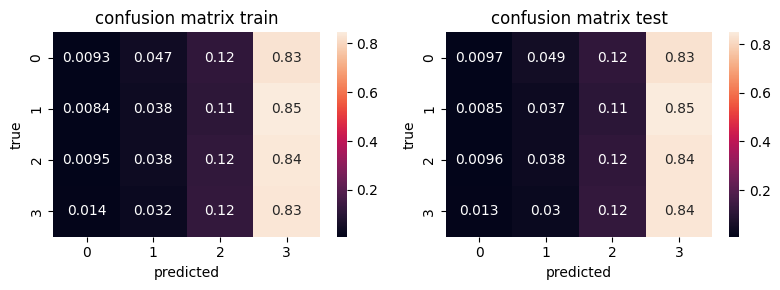

In [35]:
import seaborn as sns
for ax,i in subplots(2, usizex=4):
  if i==0: sns.heatmap(cm_tr, annot=True); plt.title("confusion matrix train")
  if i==1: sns.heatmap(cm_ts, annot=True); plt.title("confusion matrix test")
  plt.ylabel("true")
  plt.xlabel("predicted")

## is the column `FAMI_EDUCACIONPADRE` really contributing?

remove it and compare scores

In [36]:
zh = z[['ESTU_VALORMATRICULAUNIVERSIDAD', y_col]]

X = zh[[c for c in zh.columns if c!=y_col]].values
y = zh[y_col].values
X.shape, y.shape

((692500, 1), (692500,))

In [37]:
Xtr, Xts, ytr, yts = train_test_split(X,y, train_size=0.8)
lr_small = LogisticRegression()
lr_small.fit(Xtr, ytr)

LogisticRegression()

In [38]:
preds_tr = lr_small.predict(Xtr)
preds_ts = lr_small.predict(Xts)
np.mean(preds_tr==ytr), np.mean(preds_ts==yts)

(0.31740072202166064, 0.31857761732851986)

where is it helping?

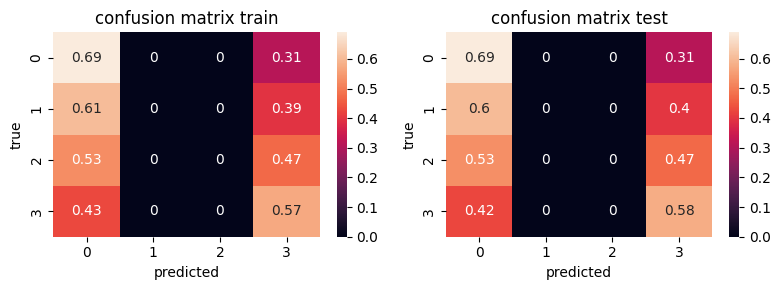

In [39]:
cm_tr = confusion_matrix(ytr, preds_tr)
cm_ts = confusion_matrix(yts, preds_ts)

# normalize by class
cm_tr = cm_tr / cm_tr.sum(axis=1).reshape(-1,1)
cm_ts = cm_ts / cm_ts.sum(axis=1).reshape(-1,1)

import seaborn as sns
for ax,i in subplots(2, usizex=4):
  if i==0: sns.heatmap(cm_tr, annot=True); plt.title("confusion matrix train")
  if i==1: sns.heatmap(cm_ts, annot=True); plt.title("confusion matrix test")
  plt.ylabel("true")
  plt.xlabel("predicted")

## We keep the first model, now we apply the same procedure to `test.csv`

observe:
- there is no `RENDIMIENTO_GLOBAL` column
- we must keep the IDs so that we can create properly the submission file

In [40]:
zt = pd.read_csv("test.csv")
zt

,Unnamed: 0,ID,PERIODO,ESTU_PRGM_ACADEMICO,ESTU_PRGM_DEPARTAMENTO,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_HORASSEMANATRABAJA,FAMI_ESTRATOVIVIENDA,FAMI_TIENEINTERNET,FAMI_EDUCACIONPADRE,FAMI_EDUCACIONMADRE,ESTU_PAGOMATRICULAPROPIO
0,0,550236,20183,TRABAJO SOCIAL,BOLIVAR,Menos de 500 mil,Menos de 10 horas,Estrato 3,Si,Técnica o tecnológica completa,Primaria completa,Si
1,1,98545,20203,ADMINISTRACION COMERCIAL Y DE MERCADEO,ANTIOQUIA,Entre 2.5 millones y menos de 4 millones,Entre 21 y 30 horas,Estrato 2,Si,Secundaria (Bachillerato) completa,Técnica o tecnológica completa,No
2,2,499179,20212,INGENIERIA MECATRONICA,BOGOTÁ,Entre 1 millón y menos de 2.5 millones,0,Estrato 3,Si,Secundaria (Bachillerato) incompleta,Secundaria (Bachillerato) completa,No
3,3,782980,20195,CONTADURIA PUBLICA,SUCRE,Entre 1 millón y menos de 2.5 millones,Entre 21 y 30 horas,Estrato 1,No,Primaria incompleta,Primaria incompleta,No
4,4,785185,20212,ADMINISTRACION DE EMPRESAS,ATLANTICO,Entre 2.5 millones y menos de 4 millones,Entre 11 y 20 horas,Estrato 2,Si,Secundaria (Bachillerato) completa,Secundaria (Bachillerato) completa,No
...,...,...,...,...,...,...,...,...,...,...,...,...
296781,296781,496981,20195,ADMINISTRACION DE EMPRESAS,BOGOTÁ,Entre 2.5 millones y menos de 4 millones,Más de 30 horas,Estrato 1,Si,Primaria incompleta,Primaria incompleta,Si
296782,296782,209415,20183,DERECHO,META,Entre 1 millón y menos de 2.5 millones,0,Estrato 4,Si,Educación profesional completa,Educación profesional completa,No
296783,296783,239074,20212,DERECHO,BOGOTÁ,Entre 2.5 millones y menos de 4 millones,Más de 30 horas,Estrato 3,Si,Secundaria (Bachillerato) completa,Educación profesional completa,No
296784,296784,963852,20195,INGENIERIA AERONAUTICA,ANTIOQUIA,Entre 5.5 millones y menos de 7 millones,Entre 11 y 20 horas,Estrato 3,Si,Educación profesional completa,Educación profesional completa,No


In [41]:
zt_ids = zt['ID'].values
zt = zt[['FAMI_EDUCACIONPADRE', 'ESTU_VALORMATRICULAUNIVERSIDAD']]
print ("shape of loaded dataframe", zt.shape)
zt.head()

shape of loaded dataframe (296786, 2)


,FAMI_EDUCACIONPADRE,ESTU_VALORMATRICULAUNIVERSIDAD
0,Técnica o tecnológica completa,Menos de 500 mil
1,Secundaria (Bachillerato) completa,Entre 2.5 millones y menos de 4 millones
2,Secundaria (Bachillerato) incompleta,Entre 1 millón y menos de 2.5 millones
3,Primaria incompleta,Entre 1 millón y menos de 2.5 millones
4,Secundaria (Bachillerato) completa,Entre 2.5 millones y menos de 4 millones


In [42]:
zt.FAMI_EDUCACIONPADRE.values[zt.FAMI_EDUCACIONPADRE.isna()] = 'no info'
zt.ESTU_VALORMATRICULAUNIVERSIDAD.values[zt.ESTU_VALORMATRICULAUNIVERSIDAD.isna()] = 'no info'


In [43]:
zt = zt.copy()
zt.ESTU_VALORMATRICULAUNIVERSIDAD = np.r_[[cmap[i] for i in zt.ESTU_VALORMATRICULAUNIVERSIDAD]]


In [44]:
zt.FAMI_EDUCACIONPADRE = ['no info' if i in ['No sabe', 'No Aplica'] else i for i in zt.FAMI_EDUCACIONPADRE.values]
FAMI_EDUCACIONPADRE_onehot_enc = np.r_[[FAMI_EDUCACIONPADRE_onehot_vals[i] for i in zt.FAMI_EDUCACIONPADRE]]
FAMI_EDUCACIONPADRE_df = pd.DataFrame(FAMI_EDUCACIONPADRE_onehot_enc, columns=[f"FAMI_EDUCACIONPADRE__{v}" for v in FAMI_EDUCACIONPADRE_onehot_vals])
zt = pd.concat([FAMI_EDUCACIONPADRE_df, zt], axis=1).drop('FAMI_EDUCACIONPADRE', axis=1)
zt.shape

(296786, 12)

In [45]:
zt

,FAMI_EDUCACIONPADRE__Técnica o tecnológica incompleta,FAMI_EDUCACIONPADRE__Técnica o tecnológica completa,FAMI_EDUCACIONPADRE__Secundaria (Bachillerato) completa,FAMI_EDUCACIONPADRE__no info,FAMI_EDUCACIONPADRE__Primaria completa,FAMI_EDUCACIONPADRE__Educación profesional completa,FAMI_EDUCACIONPADRE__Educación profesional incompleta,FAMI_EDUCACIONPADRE__Primaria incompleta,FAMI_EDUCACIONPADRE__Postgrado,FAMI_EDUCACIONPADRE__Secundaria (Bachillerato) incompleta,FAMI_EDUCACIONPADRE__Ninguno,ESTU_VALORMATRICULAUNIVERSIDAD
0,False,True,False,False,False,False,False,False,False,False,False,0.25
1,False,False,True,False,False,False,False,False,False,False,False,3.25
2,False,False,False,False,False,False,False,False,False,True,False,1.75
3,False,False,False,False,False,False,False,True,False,False,False,1.75
4,False,False,True,False,False,False,False,False,False,False,False,3.25
...,...,...,...,...,...,...,...,...,...,...,...,...
296781,False,False,False,False,False,False,False,True,False,False,False,3.25
296782,False,False,False,False,False,True,False,False,False,False,False,1.75
296783,False,False,True,False,False,False,False,False,False,False,False,3.25
296784,False,False,False,False,False,True,False,False,False,False,False,6.25


create `X` array and predict

In [46]:
X_test_data = zt[sorted(zt.columns)].values
X_test_data.shape

(296786, 12)

In [47]:
preds_test_data = lr.predict(X_test_data)

## prepare submission

first, map back the predictions to textual values

In [48]:
# inverse mapping
rmapi = {v:k for k,v in rmap.items()}
text_preds_test_data = [rmapi[i] for i in preds_test_data]


In [49]:
# create dataframe

submission = pd.DataFrame([zt_ids, text_preds_test_data], index=['ID', 'RENDIMIENTO_GLOBAL']).T
submission

,ID,RENDIMIENTO_GLOBAL
0,550236,medio-alto
1,98545,alto
2,499179,alto
3,782980,alto
4,785185,alto
...,...,...
296781,496981,alto
296782,209415,alto
296783,239074,alto
296784,963852,alto


In [50]:
# save to file ready to submit
submission.to_csv("my_submission.csv", index=False)

In [51]:
!head my_submission.csv

ID,RENDIMIENTO_GLOBAL
550236,medio-alto
98545,alto
499179,alto
782980,alto
785185,alto
58495,medio-alto
705444,medio-alto
557548,alto
519909,alto


In [52]:
submission.shape

(296786, 2)

## Send your submission to Kaggle

You must **join the competition** first

In [53]:
!kaggle competitions submit -c udea-ai4eng-20242 -f my_submission.csv -m "raul ramos submission with linear model"

100% 3.63M/3.63M [00:00<00:00, 15.7MB/s]
Successfully submitted to UDEA/ai4eng 20242 - Pruebas Saber Pro Colombia

## Things you can try

- other models (svm, random forest, gaussian, etc.)
- different parameters in the models (like `gamma` for svm, or `max_depth` for random forests). see the doc of each model in `sklearn`.
- use different preprocessing and cleaning methods for different columns
- create new columns manually, for instance,
    - group `ESTU_PRGM_ACADEMICO` into areas of knowlege (engineering, social sciences, etc.)
    - do some operation between columns (multiply, concatenate, etc.)
- integrate external data as new columns, for instance, economic data from each department in Colombia, for each different year, etc.
